# EDA

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pywaffle import  Waffle
import joypy
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix

In [3]:
spark = SparkSession.builder.config('spark.driver.memory', '16g').config('spark.executor.memory','16g').config('spark.driver.maxResultSize','0').config('spark.sql.autoBroadcastJoinThreshold','-1').config('spark.sql.broadcastTimeout','1200').config('spark.default.parallelism','8').appName("part123").getOrCreate()

# Bussiness

In [3]:
path = 'yelp_academic_dataset_business.json'
business = spark.read.json(path)
business.count()

160585

In [4]:
business_col = ['business_id','name','city','state','stars','review_count','categories','latitude','longitude','is_open', 'postal_code']
business = business.select(business_col)
tmp = business.withColumn('category', explode(split(business['categories'],','))).withColumn('category', trim('category'))
t=tmp.groupBy('category').count().orderBy('count',ascending=False).show()
regex_expr = r'\b(Restaurants|Food|Coffee|Tea|Sandwiches|Breakfast|Brunch)\b'
business = business.filter(business['categories'].rlike(regex_expr))


+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|50763|
|                Food|29469|
|            Shopping|26205|
|       Beauty & Spas|16574|
|       Home Services|16465|
|    Health & Medical|15102|
|      Local Services|12192|
|           Nightlife|11990|
|                Bars|10741|
|          Automotive|10119|
|Event Planning & ...| 9644|
|         Active Life| 9231|
|        Coffee & Tea| 7725|
|          Sandwiches| 7272|
|             Fashion| 6599|
|American (Traditi...| 6541|
|         Hair Salons| 5900|
|               Pizza| 5756|
|     Hotels & Travel| 5703|
|  Breakfast & Brunch| 5505|
+--------------------+-----+
only showing top 20 rows



In [5]:
k=tmp.filter(business['categories'].rlike(regex_expr))
ki=k.groupBy('category').count().orderBy('count',ascending=False)
kk=ki.toPandas()
df_new=kk.head(10)

<Figure size 4320x720 with 0 Axes>

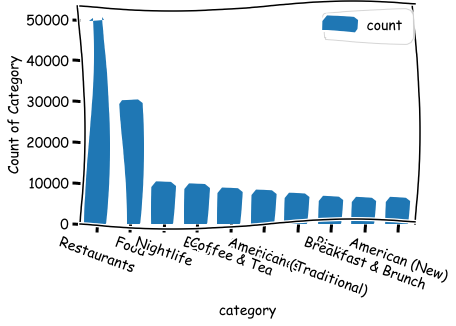

In [6]:
plt.figure(figsize=(60,10)) 
plt.xkcd(scale=5, length=400) 
df_new.plot(x='category',y='count',kind='bar') 
plt.ylabel('Count of Category') 
plt.xticks(rotation=-20) 
plt.show()

In [7]:
df=tmp.toPandas()

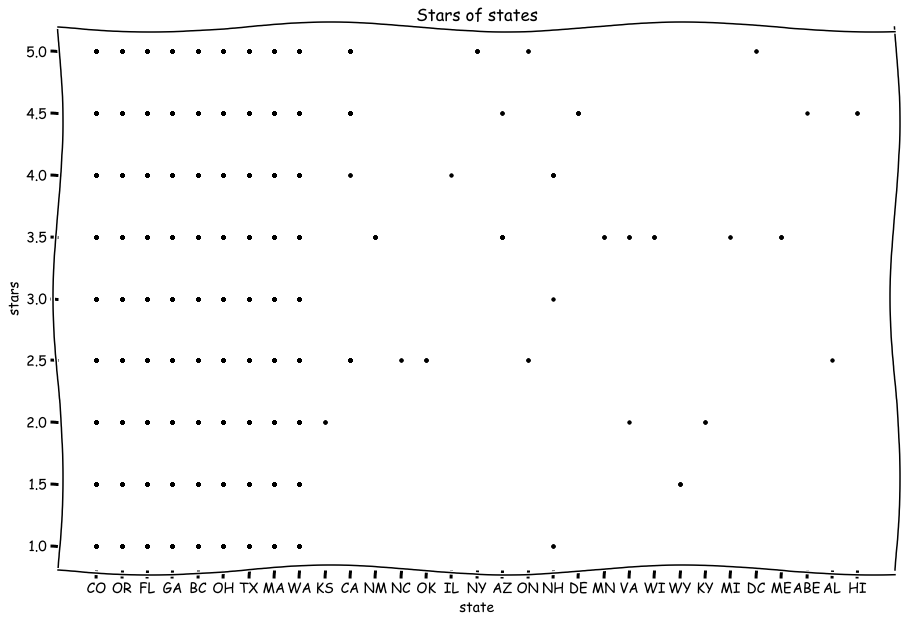

In [8]:
fig = plt.figure(figsize=(15,10))
x=df['state']
y=df['stars']
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title('Stars of states')
ax1.set_xlabel('state')
ax1.set_ylabel('stars')
ax1.scatter(x, y, c='k', marker='.')
plt.show()

/Users/yanxi/opt/anaconda3/lib/python3.8/site-packages/pywaffle/waffle.py:394: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  self.ax = self.add_subplot(loc, aspect="equal")


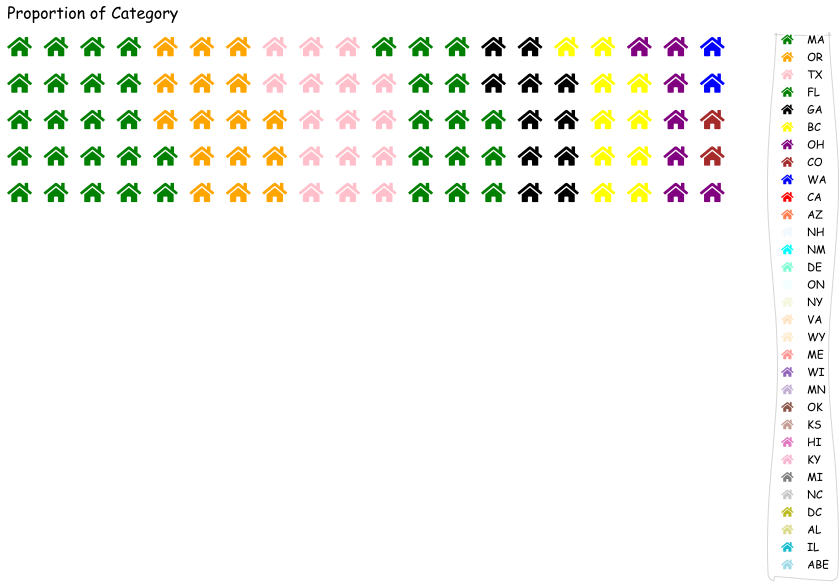

In [9]:
flattype = dict(df['state'].value_counts()/len(df)*100)
plt.figure(figsize=(20,10),
    FigureClass=Waffle, 
    plots={
        '211': {
            'values': flattype,
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':11},
            'title': {'label': 'Proportion of Category', 'loc': 'left', 'fontsize':16}
        }
    },
    rows=5, 
    colors=['green','orange','pink',"green", 'black', 'yellow','purple', 'brown','blue','red','coral','aliceblue', 'aqua', 'aquamarine', 'azure', 'beige','bisque', 'blanchedalmond', '#ff9896', '#9467bd', '#c5b0d5','#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f','#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5'],
    icons='home', 
    font_size=22, 
    icon_legend=True)
    
plt.show()

In [10]:
c=business.groupBy('city').count().orderBy('count',ascending=False)
ci=c.toPandas()
ci=ci.head(10)

Text(0.5, 1.0, 'Count of reviews grouped by cities')

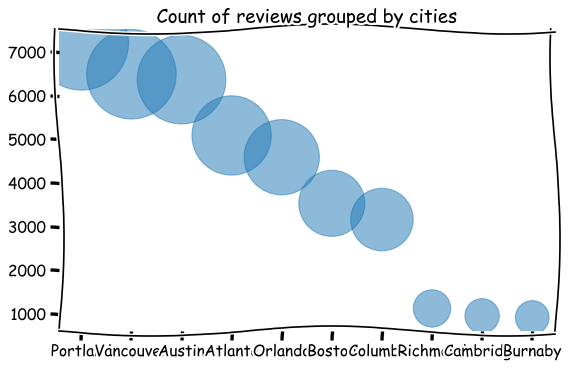

In [11]:
fig,ax=plt.subplots(figsize=(8,5),dpi=80)
ax.scatter(ci['city'],ci['count'],s=ci['count'],alpha=0.5)
ax.set_title('Count of reviews grouped by cities')

# Review

In [12]:
path = 'yelp_academic_dataset_review.json'
review = spark.read.json(path)

In [13]:
review.show(10)
review = review.withColumn('year', substring('date',1,4).astype('int'))
review = review.withColumn('month', substring('date',6,2).astype('int'))
review = review.withColumn('day', substring('date',9,2).astype('int'))

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|buF9druCkbuXLX526...|   1|2014-10-11 03:34:02|    1|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...|     3|ak0TdVmGKo4pwqdJS...|
|RA4V8pr014UyUbDvI...|   0|2015-07-03 20:38:25|    0|8bFej1QE5LXp4O05q...|  4.0|This store is pre...|     1|YoVfDbnISlW0f7abN...|
|_sS2LBIGNT5NQb6PD...|   0|2013-05-28 20:38:06|    0|NDhkzczKjLshODbqD...|  5.0|I called WVM on t...|     0|eC5evKn1TWDyHCyQA...|
|0AzLzHfOJgL7ROwhd...|   1|2010-01-08 02:29:15|    1|T5fAqjjFooT4V0OeZ...|  2.0|I've stayed at ma...|     1|SFQ1jcnGguO0LYWnb...|
|8zehGz9jnxPqXtOc7...|   0|2011-07-28 18:05:01|    0|sjm_uUcQVxab_EeLC...|  4.0|The food i

In [14]:
review_col = ['review_id','business_id','user_id','year','month','day','stars','useful','funny','cool','text']
review = review.select(review_col)

In [15]:
re=review.groupBy('year').count().orderBy('year')
dr=re.toPandas()
dr

,year,count
0,2004,52
1,2005,6439
2,2006,23819
3,2007,71916
4,2008,150436
5,2009,213797
6,2010,317583
7,2011,431192
8,2012,472441
9,2013,555740


Text(0.5, 1.0, 'Count of reviews grouped by years')

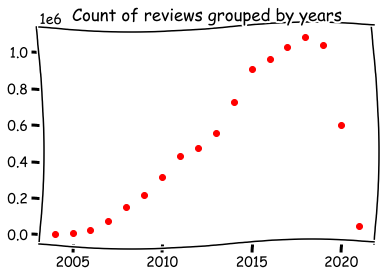

In [16]:
fig,ax=plt.subplots()
ax.scatter(dr['year'],dr['count'],c='red')
ax.set_title('Count of reviews grouped by years')

In [17]:
re_col = ['stars','useful','funny','cool']
rev=review.select(re_col)
rr=rev.toPandas()

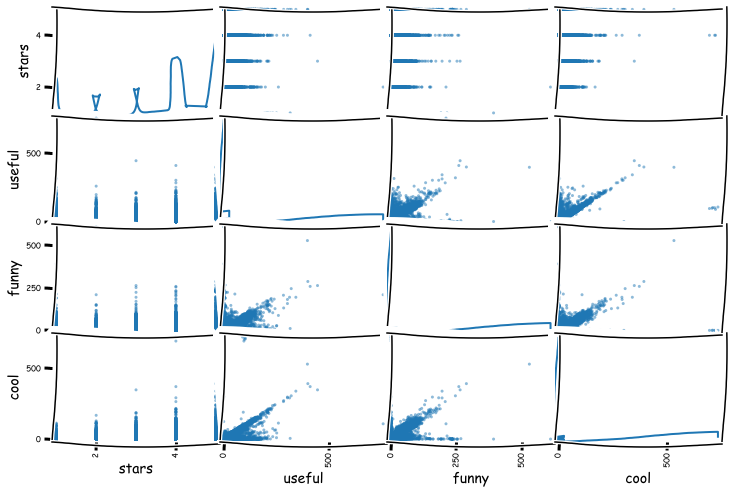

In [18]:
df_matrix=scatter_matrix(rr.loc[:,:],figsize=(12,8),diagonal='kde')
plt.show()

# User

In [4]:
path = 'yelp_academic_dataset_user.json'
user = spark.read.json(path)

In [5]:
user_col = ['user_id','name','review_count','yelping_since','friends','useful','funny','cool','fans','average_stars']
user = user.select(user_col)

In [6]:
usei = user.withColumn('review_count', user['review_count'].astype('int'))

In [12]:
use=usei.orderBy('review_count',ascending=False).filter(usei['review_count']>2000)

In [13]:
ur=use.repartition(2000)

In [14]:
urr=ur.toPandas()

Text(0.5, 1.0, 'Count of reviews grouped by users')

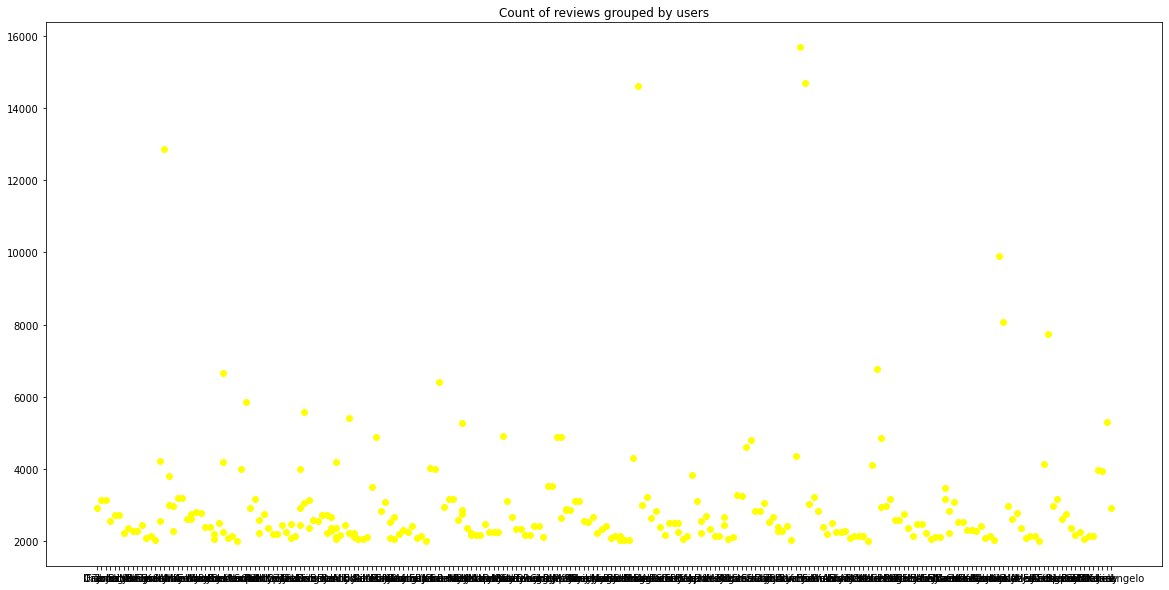

In [15]:
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(urr['name'],urr['review_count'],c='yellow')
ax.set_title('Count of reviews grouped by users')